In [1]:
from PIL import Image
import math
import numpy as np
np.set_printoptions(threshold=np.inf, linewidth=np.inf) 
import matplotlib.pyplot as plt
import cv2

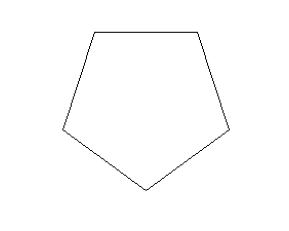

In [2]:
img = Image.open('pentagon.jpg').convert('L')
img = np.array(img)
h, w = img.shape

plt.imshow(img, cmap='gray')
plt.axis('off')

def filtering(img, filter):   # convolution
    h, w = img.shape
    fSize = len(filter)       # filter Size
    pSize = (fSize-1) // 2    # padding Size
    
    img = np.pad(img, ((pSize,pSize),(pSize,pSize)), 'constant', constant_values=0)
    filteredImg = np.zeros((h,w))
    
    for i in range(pSize,h+pSize):      # operate on ground-truth pixel
        for j in range(pSize,w+pSize):
            product = img[i-pSize:i+pSize+1,j-pSize:j+pSize+1] * filter
            filteredImg[i-pSize][j-pSize] = product.sum()
            
    return filteredImg

(-0.5, 267.5, 211.5, -0.5)

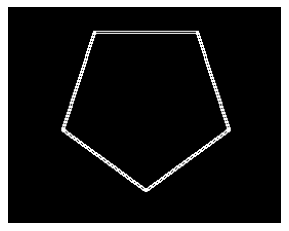

In [3]:
# 1) Find the edge map using Sobel mask.
def sobelEdgeDetection(img, threshold):
    mx = [ [-1,0,1],
           [-2,0,2],
           [-1,0,1] ]
    my = [ [-1,-2,-1],
           [ 0, 0, 0],
           [ 1, 2, 1] ]
    
    dx = filtering(img,mx)
    dy = filtering(img,my)
    s = np.sqrt(dx**2 + dy**2)  #strength
    o = np.arctan2(dx, dy)      #orientation
    f = s.copy()                #final
    f[ f>=threshold ] = 255
    f[ f<threshold ] = 0
    return dx, dy, s, o, f

dx,dy,s,o,f  = sobelEdgeDetection(img, 200)

plt.imshow(f, cmap='gray')
plt.axis('off')

In [4]:
def hough_line(img):
    h, w = img.shape
    
    # theta: -90 ~ 180
    thetas = np.deg2rad(np.arange(-90, 180))
    
    # rho 범위 지정, 대각선 최대 거리
    diag_len = int(np.ceil(np.sqrt(h * h + w * w))) 
    rhos = np.arange(0, diag_len)                

    # hough domain
    hough_domain = np.zeros((len(rhos),len(thetas)))
    # non-Zero index 추출
    yindex, xindex = np.nonzero(img)
    
    for i in range(len(yindex)):
        x = xindex[i]
        y = yindex[i]
        for t in range(len(thetas)):
            rho = round( x * np.cos(thetas[t]) + y * np.sin(thetas[t]) )
            hough_domain[rho, t] += 1
    return  hough_domain, thetas, rhos
                    
hough_domain, thetas, rhos = hough_line(f)

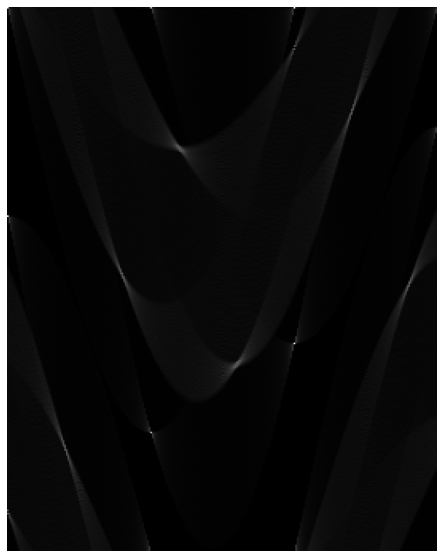

In [5]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(hough_domain, 'gray')

In [6]:
threshold = 90
idx = np.where(hough_domain >= threshold)
thetas_idx = idx[1]
rhos_idx = idx[0]
for i in range(len(rhos_idx)):
    theta = thetas[thetas_idx[i]]
    rho   = rhos_idx[i]
    print('theta: ',theta,'/  rho: ', rho)
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    scale = h+w               #적당히 크게
    x1 = int(x0 - scale*b)
    y1 = int(y0 + scale*a)
    x2 = int(x0 + scale*b)
    y2 = int(y0 - scale*a)
    
    # 직선 그리기
    try:  
        m = (y2-y1)/(x2-x1)
    except:
        pass
    
    for x in range(w):
        try:
            y = round( m*(x-x1)  ) + y1
            if x>0 and y>0:
                img[y,x] = 0
        except:
                pass
            
    try:
        m = (x2-x1)/(y2-y1)
    except:
        pass
    
    for y in range(h):
        try:
            x = round( m*(y-y1)  ) + x1
            if x>0 and y>0:
                img[y,x] = 0
        except:
                pass

theta:  -1.5707963267948966 /  rho:  0
theta:  0.0 /  rho:  0
theta:  1.5707963267948966 /  rho:  0
theta:  1.5707963267948966 /  rho:  24
theta:  1.5707963267948966 /  rho:  26
theta:  2.199114857512855 /  rho:  64
theta:  2.199114857512855 /  rho:  66
theta:  0.3141592653589793 /  rho:  88
theta:  0.3141592653589793 /  rho:  89
theta:  0.33161255787892263 /  rho:  90
theta:  -1.5707963267948966 /  rho:  131
theta:  -0.33161255787892263 /  rho:  166
theta:  -0.3141592653589793 /  rho:  167
theta:  -0.3141592653589793 /  rho:  169
theta:  2.827433388230814 /  rho:  173
theta:  2.827433388230814 /  rho:  175
theta:  2.8099800957108707 /  rho:  176
theta:  1.5707963267948966 /  rho:  211
theta:  0.9424777960769379 /  rho:  223
theta:  0.9599310885968813 /  rho:  223
theta:  0.9250245035569946 /  rho:  224
theta:  0.9424777960769379 /  rho:  225
theta:  0.9250245035569946 /  rho:  226
theta:  0.0 /  rho:  267
theta:  -0.9424777960769379 /  rho:  276
theta:  -0.9424777960769379 /  rho:  27

(-0.5, 267.5, 211.5, -0.5)

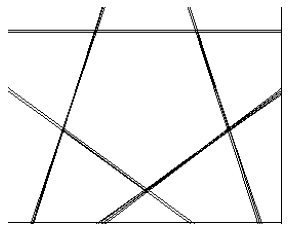

In [7]:
plt.imshow(img, 'gray')
plt.axis('off')

0.0 1.5707964
0.0 1.5707964
211.0 1.5707964
211.0 1.5707964
0.0 0.0
0.0 0.0
267.0 0.0
267.0 0.0
223.0 0.94247776
223.0 0.94247776
26.0 1.5707964
26.0 1.5707964
225.0 0.94247776
225.0 0.94247776
24.0 1.5707964
24.0 1.5707964
-169.0 2.8274333
-169.0 2.8274333
-167.0 2.8274333
-167.0 2.8274333
64.0 2.1991148
64.0 2.1991148
66.0 2.1991148
66.0 2.1991148
224.0 0.9250245
224.0 0.9250245
90.0 0.33161256
90.0 0.33161256
89.0 0.31415927
89.0 0.31415927


(-0.5, 267.5, 211.5, -0.5)

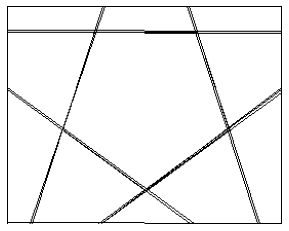

In [8]:
# 2) From binary edge map, apply the Hough transform.
img = Image.open('pentagon.jpg').convert('L')
img = np.array(img)
h, w = img.shape
      # cv2.HoughLines(image, rho, theta, threshold  # rho : rho 정밀도 # theta : theta 정밀도
lines = cv2.HoughLines(f.astype('uint8'),1,np.pi/180,90)

for line in lines:
    rho,theta = line[0]
    print(rho, theta)
    print(rho, theta)
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    scale = 1000 
    x1 = int(x0 - scale*b)
    y1 = int(y0 + scale*a)
    x2 = int(x0 + scale*b)
    y2 = int(y0 - scale*a)
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),1)

plt.imshow(img, 'gray')
plt.axis('off')